# Data Preprocessing

In [2]:
import pandas as pd
import stumpy
import numpy as np

import time # just for dev purpose
from IPython.display import display # Just for displaying DF nicely

from itertools import product

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.patches import Rectangle
import datetime as dt

from sklearn.cluster import KMeans

from util.util import *
from util.const import conceptNames

### Reading only one file

Agostinelli Logs (run this or Sparkasse Example)

In [36]:
# Validation Logs
csvPath = "logs/smartRPA/"

filename = "2020-11-07_17-28-29__250_25_40_3.csv"
#filename = "2020-11-07_17-41-57__1000_100_80_4.csv"
#filename = "2020-11-07_21-09-26__750_100_80_5.csv"
#filename = "2020-11-17_15-05-40__500_100_40_4.csv"

filenamesList = ["2020-11-17_15-05-40__500_100_40_4.csv","2020-11-07_21-09-26__750_100_80_5.csv",
                 "2020-11-07_17-41-57__1000_100_80_4.csv","2020-11-07_17-28-29__250_25_40_3.csv"]

df = pd.read_csv(csvPath + filename, encoding = "latin-1")

Sparkasse 1h Recording Sample by Tom (run this or Agostinelli Logs)

In [10]:
# Sparkasse 1h test log
csvPath = "logs/Banking/"

filename = "TSMD Log Sparkass_combined.csv"
df = pd.read_csv(csvPath + filename, encoding = "latin-1")

Validation Logs created in validationLogCreation.ipynb

In [3]:
# Validation Logs
# csvPath = "logs/smartRPA/Validation/"
csvPath = "logs/smartRPA/percentageComparison/"

filename = "LenLog_1_1_30_15_10_4500.csv"

df = pd.read_csv(csvPath + filename, encoding = "latin-1")

# Getting the tuple data ready

Encoding can be done in two ways with our approach:
- Continuous hot encoding which uses the temporal similarity as applications used earlier in the process get a lower value and thus are closer in the encoding
- Window Based Co-Occurance of values, which focuses on the co-occurance of values, in our case applications and concept names (actions)
    - Create a co-occurance matrix with n values distance measure
    - Apply spectral ordering of co-occuring values

In [4]:
application_co_matrix = co_occurrence_matrix_n(df, 2, "application")
application_matrix = spectral_ordering_cooccurrence(application_co_matrix)

In [5]:
concept_name_co_matrix = co_occurrence_matrix_n(df, 2, "concept:name")
concept_name_matrix = spectral_ordering_cooccurrence(concept_name_co_matrix)
# concept_name_matrix

#### Agostinelli Log

In [6]:
#### Encoding of Application ####
# Update dict creation to sort the data before to create meaningful dicts -> Equal applications are grouped together for example
# By Appearing in the UI Log > Continuous hot encoding
applicationDict = createDict(set(df['application'].unique()))
appByOrder = applicationDict
# By co-occurance spectral ordering based on application_matrix
applicationDict = createDict(list(application_matrix))
appByCooccurance = applicationDict

# Add as new column to the dataframe
df['application:id'] = df.apply(lambda row: get_key(row, appByOrder, 'application'), axis=1)

#### Encoding of concept:name / action ####
# Concept Name Encoding -> Use One
# By Appearing in the UI Log > Continuous hot encoding
conceptNamesDict = createDict(list(df['concept:name'].unique()))
conceptByName = conceptNamesDict
# By Appearing in the UI Log > Continuous hot encoding
conceptNamesDict = createDict(list(df.sort_values(by=['concept:name'])['concept:name'].unique()))
conceptSorted = conceptNamesDict
# By Ordering on the application id
conceptNamesDict = createDict(list(df.sort_values(by=['application:id'])['concept:name'].unique()))
conceptByApp = conceptNamesDict
# By all possible action types
# conceptNamesDict = createDict(conceptNames)
# By Co-Occurrance and spectral ordering
# conceptNamesDict = createDict(list(concept_name_matrix))
conceptByOccurance = conceptNamesDict

df['concept:name:id'] = df.apply(lambda row: get_key(row, conceptNamesDict, 'concept:name'), axis=1)

#### Encoding of Category ####
# Categories > No specific encoding sequence as it is few values. Does not matter
categoriesDict = createDict(set(df.sort_values(by=['category'])['category'].unique()))

df['category:id'] = df.apply(lambda row: get_key(row, categoriesDict, 'category'), axis=1)


print(f"The number of concept names is {len(conceptNamesDict)}, of applications is {len(applicationDict)}, and categories is {len(categoriesDict)}")
print(df[["time:timestamp",'concept:name', 'application', 'category', 'concept:name:id', 'application:id', 'category:id']])

The number of concept names is 40, of applications is 10, and categories is 3
               time:timestamp          concept:name      application  \
0     2020-02-01T05:55:26.000                newTab           Chrome   
1     2020-06-19T16:53:30.000               deleted         Explorer   
2     2020-09-28T10:30:55.000            openFolder         Explorer   
3     2020-01-07T06:11:53.000          cancelDialog           Chrome   
4     2020-10-29T14:10:54.000  doubleClickEmptyCell  Microsoft Excel   
...                       ...                   ...              ...   
4495  2020-08-16T06:48:36.000        modifyBookmark           Chrome   
4496  2020-01-01T09:52:08.000               deleted         Explorer   
4497  2020-07-12T20:08:17.000                  copy        Clipboard   
4498  2020-02-22T23:04:14.000            openFolder         Explorer   
4499  2020-06-08T06:11:19.000          cancelDialog           Chrome   

             category  concept:name:id  application:id  c

### Graphical comparison of continuous vs spectral encoding

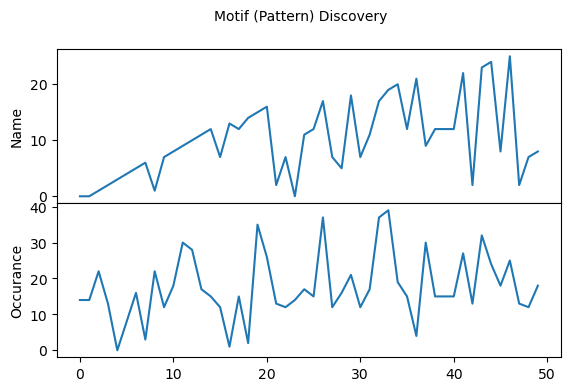

Mean alteration rate between byApp order: 11.452180172768408
Mean alteration rate between byOccurance order: 12.2812114356232


In [22]:
comparison_of_methods_df = df.copy()
comparison_of_methods_df = comparison_of_methods_df[["time:timestamp",'concept:name', 'application', 'category']]

comparison_of_methods_df['byOccurance'] = comparison_of_methods_df.apply(lambda row: get_key(row, conceptByOccurance, 'concept:name'), axis=1)
comparison_of_methods_df['byName'] = comparison_of_methods_df.apply(lambda row: get_key(row, conceptByName, 'concept:name'), axis=1)

comparison_of_methods_df_50 = comparison_of_methods_df.iloc[:50]

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(6.5, 4))
plt.suptitle('Motif (Pattern) Discovery', fontsize='10')

axs[0].plot(comparison_of_methods_df_50['byName'])
axs[0].set_ylabel('Name', fontsize='10')
axs[1].plot(comparison_of_methods_df_50['byOccurance'])
axs[1].set_ylabel('Occurance', fontsize='10')
plt.show()

# Calculate differences between consecutive values (avoid first element)
differences_byOcc = comparison_of_methods_df['byOccurance'].diff(periods=-1)  # Avoids unnecessary row iteration
differences_byOcc.iloc[0] = pd.NA  # Set difference for the first row to not-a-number (optional)

differences_byName = comparison_of_methods_df['byName'].diff(periods=-1) 
differences_byName.iloc[0] = pd.NA  


# Calculate the mean of absolute differences (mean jump)
mean_jump_app = differences_byOcc.abs().mean()
mean_jump_conceptname = differences_byName.abs().mean()

print("Mean alteration rate between byApp order:", mean_jump_app) 
print("Mean alteration rate between byOccurance order:", mean_jump_conceptname) # score does not change a lot, best score around 9.3/9.4

Make the multi dimensional Agostinelli log one dimensional using another tuple generator

Using the ideas ('concept:name:id','application:id', 'category:id') generated earlier in the process based on the dictonaries 

In [8]:
numbersDF = df[['concept:name:id', 'application:id', 'category:id']]

# Generate unique tuples for indexing the individual combinations of the rows mentioned
unique_df = numbersDF.drop_duplicates(subset=numbersDF.columns, keep='first')
tuples = [tuple(row[['concept:name:id', 'application:id', 'category:id']]) for i, row in unique_df.sort_values(by='application:id').iterrows()]
       
df['tuple:id'] = df.apply(lambda row: get_id(row, tuples, columns=['concept:name:id','application:id', 'category:id']), axis=1)
# Print the updated DataFrame
print(df['tuple:id'])

0       32
1       10
2        9
3       40
4       25
        ..
4495    28
4496    10
4497    27
4498     9
4499    40
Name: tuple:id, Length: 4500, dtype: int64


### Save DF after processing for temporary analysis

In [24]:
filepath = "logs/your_data.csv"
df.to_csv(filepath, index=False)

### Display different ordering clusters
Timeseries data is continuous and thus the process mining data has to be transformed in a way that it does represent a continuous spectrum of values.

We test the following approaches to create the timeseries integer values for a continuous spectrum:
- Tuple ID by occurance: The first occurance gets ID=1, the second ID=2, and so on. This leads to a spectrum based on value occurance
- Tuple ID by application: Similar applications should get similar tuple IDs. Thus, we define a list of applications that can occurr in the log and order the applications by similarity. E.g. Firefox and Chrome have closer tuple values compared to Firefox and Outlook.
- Tuple ID by action: Similar actions get similar IDs. Thus, we cluster the actions based on their generic type. We suggest the clustering based on:
    - mouse interactions, keyboard interactions, and other interactions.
    - the generic action types "Open" "Close" "Navigate" "Transform" "Transfer" "Empty" "Conclude"

Based on the sorting we check the quality of the data distribution by the mean difference between the tuple IDs in the log.
I.e. we calculate the difference between all occurring values in the log and take the mechanism creating the smallest average difference between consequitive occurances.

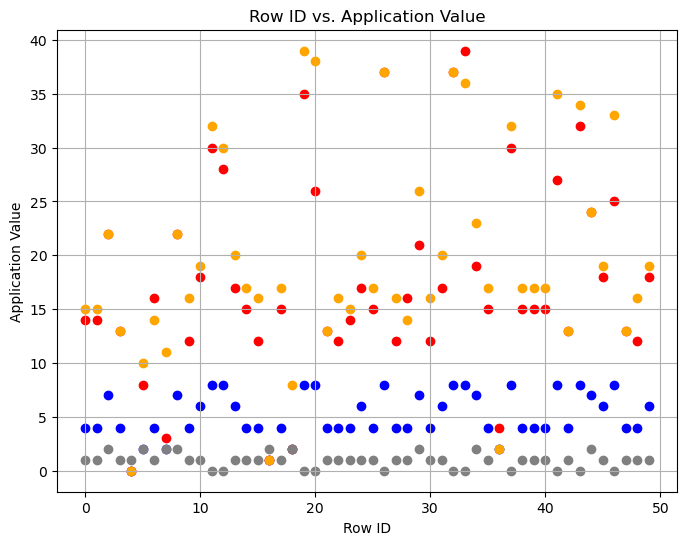

In [25]:
first_50_rows = df.iloc[:50]

# Get row IDs (index starts from 0)
row_ids = first_50_rows.index

# Extract application values
application_values = first_50_rows['application:id'].to_numpy()  # Convert to NumPy array for efficiency
concept_names = first_50_rows['concept:name:id'].to_numpy()  
categories_values = first_50_rows['category:id'].to_numpy()  
tuple_ids = first_50_rows['tuple:id'].to_numpy() 

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(row_ids, application_values, color='blue')
plt.scatter(row_ids, concept_names, color='red')
plt.scatter(row_ids, categories_values, color='grey')
plt.scatter(row_ids, tuple_ids, color='orange')
plt.xlabel('Row ID')
plt.ylabel('Application Value')
plt.title('Row ID vs. Application Value')
plt.grid(True)
plt.show()

In [26]:
# Calculate differences between consecutive values (avoid first element)
differences_app = df['application:id'].diff(periods=-1)  # Avoids unnecessary row iteration
differences_app.iloc[0] = pd.NA  # Set difference for the first row to not-a-number (optional)

differences_concept = df['concept:name:id'].diff(periods=-1) 
differences_concept.iloc[0] = pd.NA  

differences_cat = df['category:id'].diff(periods=-1)  
differences_cat.iloc[0] = pd.NA  

differences_tuple = df['tuple:id'].diff(periods=-1)  
differences_tuple.iloc[0] = pd.NA

# Calculate the mean of absolute differences (mean jump)
mean_jump_app = differences_app.abs().mean()
mean_jump_conceptname = differences_concept.abs().mean()
mean_jump_cat = differences_cat.abs().mean()
mean_jump_tup = differences_tuple.abs().mean()

print("Mean alteration rate between consecutive application:id values:", mean_jump_app) # Best score so far when just taking apps as they come at 1.8
print("Mean alteration rate between consecutive concept:name:id values:", mean_jump_conceptname) # best score if only concepts are considered that appear in the df at 12.6 (if all actions are considered ~36)
print("Mean alteration rate between consecutive category:id values:", mean_jump_cat) 
print("Mean alteration rate between consecutive tuple id values:", mean_jump_tup) # score does not change a lot, best score around 9.3/9.4

Mean alteration rate between consecutive application:id values: 2.531160016454134
Mean alteration rate between consecutive concept:name:id values: 11.452180172768408
Mean alteration rate between consecutive category:id values: 0.7213081036610448
Mean alteration rate between consecutive tuple id values: 11.680944055944057


#### Plotting Deviation values
Multiple Box plots showing the deviation rate between all sorting variants for application and concept:name.
Overall goal of these plots is to outline, which variant has the lowest deviation values, because values closer grouped around the mean should generate a smaller Euclidian distance in the matrix calculation.

We generate plots for:
- Application ID ordered by Continuous hot encoding
- Application ID ordered by Co-occurance spectral ordering
- Concept:name ordered by Name
- Concept:name ordered by Application Occurance
- Concept:name ordered by their own continuous hot encoding

Based on the plotted data for Agostinellis Validation Logs, the Sparkasse data by Hohenadl, and the randomly generated validation log based on Agostinellis data, we can show, that the occurance variant has the second and third quartile grouped in closer proximity. Thus, similar values are ordered with less deviation compared to the other sorting methods.

Mean alteration rate C:N:Order: 12.2812114356232
Mean alteration rate C:N:App: 11.452180172768408
Mean alteration rate C:N:Occurance: 11.452180172768408


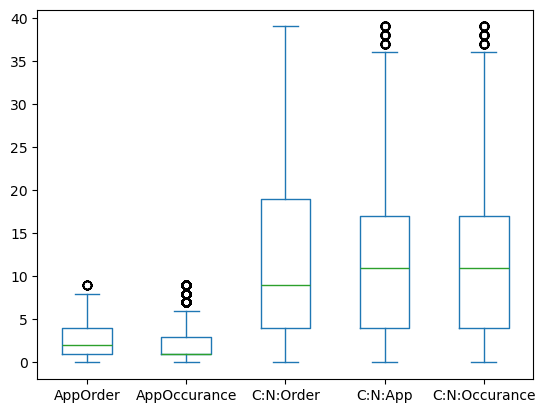

In [27]:
# Data validation
# Used to validate the co-occurance to have less outliers and a more compact dataframe
method_validation_df = df.copy()
method_validation_df['application:id:order'] = method_validation_df.apply(lambda row: get_key(row, appByOrder, 'application'), axis=1)
method_validation_df['application:id:occurance'] = method_validation_df.apply(lambda row: get_key(row, appByCooccurance, 'application'), axis=1)
method_validation_df['category:id'] = method_validation_df.apply(lambda row: get_key(row, categoriesDict, 'category'), axis=1)
method_validation_df['concept:name:byName'] = method_validation_df.apply(lambda row: get_key(row, conceptByName, 'concept:name'), axis=1)
method_validation_df['concept:name:byApp'] = method_validation_df.apply(lambda row: get_key(row, conceptByApp, 'concept:name'), axis=1)
method_validation_df['concept:name:byOcc'] = method_validation_df.apply(lambda row: get_key(row, conceptByOccurance, 'concept:name'), axis=1)

app_id_order = method_validation_df['application:id:order'].diff(periods=-1)  
app_id_order.iloc[0] = pd.NA
app_id_occurance = method_validation_df['application:id:occurance'].diff(periods=-1)  
app_id_occurance.iloc[0] = pd.NA
concept_id_by_name = method_validation_df['concept:name:byName'].diff(periods=-1)  
concept_id_by_name.iloc[0] = pd.NA
concept_id_by_app = method_validation_df['concept:name:byApp'].diff(periods=-1)  
concept_id_by_app.iloc[0] = pd.NA
concept_id_by_occ = method_validation_df['concept:name:byOcc'].diff(periods=-1)  
concept_id_by_occ.iloc[0] = pd.NA

data = {'AppOrder': app_id_order.abs(), 'AppOccurance': app_id_occurance.abs(), 'C:N:Order': concept_id_by_name.abs(), 
        'C:N:App': concept_id_by_app.abs(), 'C:N:Occurance': concept_id_by_occ.abs()}
deviationRate = pd.DataFrame(data)

ax = deviationRate[['AppOrder','AppOccurance','C:N:Order','C:N:App','C:N:Occurance']].plot.box()

print("Mean alteration rate C:N:Order:", concept_id_by_name.abs().mean())
print("Mean alteration rate C:N:App:", concept_id_by_app.abs().mean())
print("Mean alteration rate C:N:Occurance:", concept_id_by_occ.abs().mean())

Modelling the data in a 3D space

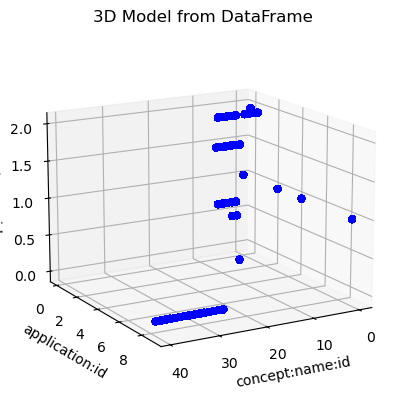

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract data from each column
x = df['concept:name:id']
y = df['application:id']
z = df['category:id']

# Plot the points
ax.scatter(x, y, z, c='blue', alpha=0.7)

# Set labels and title
ax.set_xlabel('concept:name:id')
ax.set_ylabel('application:id')
ax.set_zlabel('category:id')
ax.set_title('3D Model from DataFrame')

# Adjust view angles (optional)
ax.view_init(elev=15, azim=60)

# Show the plot
plt.show()

# Motife Discovery

From Time https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html#Find-a-Motif-Using-STUMP:

Time series motifs are approximately repeated subsequences found within a longer time series. Being able to say that a subsequence is “approximately repeated” requires that you be able to compare subsequences to each other. In the case of STUMPY, all subsequences within a time series can be compared by computing the pairwise z-normalized Euclidean distances and then storing only the index to its nearest neighbor. This nearest neighbor distance vector is referred to as the matrix profile and the index to each nearest neighbor within the time series is referred to as the matrix profile index. Luckily, the stump function takes in any time series (with floating point values) and computes the matrix profile along with the matrix profile indices and, in turn, one can immediately find time series motifs.

### Window Size Calculation

I propose a window size calculation based on break time. 
The break time method (windowSizeByBreak) calculates the percentil break time and then the avg. number of events between these breaks occuring.

E.g. the avg. break time is 300 seconds and the following breaks between event time stamps exist:
[100,210,333,100,11,300,222] 

Then there are on avg. 3 events between these breaks: Thus, the window size is set to 3.

In [29]:
# If the percentil is increased the number of elements should increate, but it does not, it decreases
# Something is wrong with this functionallity
# Occarm´s Razor: The most simple solution might be the best: Just take a guess instead of "Rätselraten"
def windowSizeCalculation(): # Get out of the function to work again // Just made into a function to run the notebook completly
    percentil = 75
    breakTime = 300 # 300 = 5 Min, 600 = 10 min, 900 = 15 min
    third_quartile, quartile_indices, average_elements = windowSizeByBreak(df, "time:timestamp", breakTime, percentil)
    if average_elements is not None:
        print(f"Average number of elements between {percentil} percentil breaks occurrences: {average_elements:.2f}")
    else:
        print("Not enough data to calculate average")

    print(f"The {percentil} percentil time difference between clicks is {third_quartile}s")

    # Checking the avg. case length:
    # Count occurrences of each concept name
    concept_counts = df['case:concept:name'].value_counts()
    average_entries = concept_counts.mean()
    print(f"The average case length is {average_entries} entries.")

### Run for smartRPA based File for univariate data

Window size selection is challenging task for motif discovery as they occurr independent and often. Motifs can have varying length and thus be hard to find.
More research is needed as stated in https://link.springer.com/chapter/10.1007/978-3-031-24378-3_6

In [9]:
starting_row = 0
ending_row = len(df)-1
#Extract ids and rows
ids = df.loc[starting_row:ending_row,'tuple:id'].tolist()
rows = [i for i in range(len(df.loc[starting_row:ending_row,'tuple:id']))]

# Manually set window size
window_size = 25

event_series = df.loc[starting_row:ending_row,'tuple:id'].values.astype(float)
tm_matrix = stumpy.stump(event_series, window_size)

motif_idx_tm = np.argsort(tm_matrix[:, 0])[0]
nearest_neighbor_idx_tm = tm_matrix[motif_idx_tm, 1]

print(f"The window size is {window_size}")
print(f"The motif is located at index {motif_idx_tm}")
print(f"The nearest neighbor is located at index {nearest_neighbor_idx_tm}\n")

The window size is 25
The motif is located at index 2882
The nearest neighbor is located at index 1113



In [ ]:
# print(len(df))
# df.drop(range(nearest_neighbor_idx_tm,nearest_neighbor_idx_tm+window_size),axis=0,inplace=True)
# print(len(df))

### Plotting

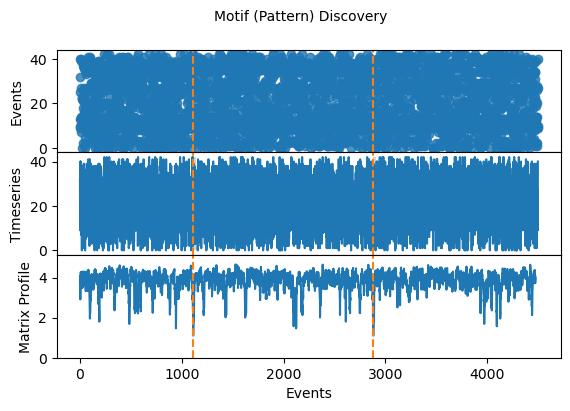

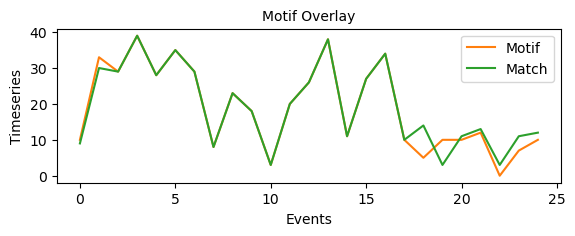

In [10]:
fig, axs = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0}, figsize=(6.5, 4))
plt.suptitle('Motif (Pattern) Discovery', fontsize='10')

#Plot Event data
axs[0].scatter(rows, ids, alpha=0.8)
axs[0].set_ylabel('Events', fontsize='10')
# Plot Timeseries data
axs[1].plot(event_series)
axs[1].set_ylabel('Timeseries', fontsize='10')
rect = Rectangle((motif_idx_tm, 0), window_size, event_series.max(), facecolor='lightgrey')
axs[1].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx_tm, 0), window_size, event_series.max(), facecolor='lightgrey')
axs[1].add_patch(rect)
# Plot Matrix profiles
axs[2].set_xlabel('Events', fontsize ='10')
axs[2].set_ylabel('Matrix Profile', fontsize='10')
axs[2].set_ylim(top=tm_matrix[:, 0].max()*1.1) #displaying the max value with some uplift for space in Graph
axs[2].plot(tm_matrix[:, 0])
# Adding Dashed lines
axs[0].axvline(x=motif_idx_tm, linestyle="dashed", color='C1')
axs[0].axvline(x=nearest_neighbor_idx_tm, linestyle="dashed", color='C1')
axs[1].axvline(x=motif_idx_tm, linestyle="dashed", color='C1')
axs[1].axvline(x=nearest_neighbor_idx_tm, linestyle="dashed", color='C1')
axs[2].axvline(x=motif_idx_tm, linestyle="dashed", color='C1')
axs[2].axvline(x=nearest_neighbor_idx_tm, linestyle="dashed", color='C1')
plt.show()

# Display Pattern overlay
fig, ax = plt.subplots(figsize=(6.5, 2))
plt.title('Motif Overlay', fontsize='10')
ax.set_xlabel("Events", fontsize='10')
ax.set_ylabel("Timeseries", fontsize='10')
# Plot motif and nearest neighbor window
ax.plot(event_series[motif_idx_tm:motif_idx_tm+window_size], color='C1', label="Motif")
ax.plot(event_series[nearest_neighbor_idx_tm:nearest_neighbor_idx_tm+window_size], color='C2', label="Match")
plt.legend(loc="best",fontsize=10)
plt.show()

In [78]:
# Print the desired rows
display(df.iloc[motif_idx_tm:min(motif_idx_tm + window_size, len(df))])
display(df.iloc[nearest_neighbor_idx_tm:min(nearest_neighbor_idx_tm + window_size, len(df))])

,Unnamed: 0,case:concept:name,case:creator,lifecycle:transition,time:timestamp,org:resource,category,application,concept:name,event_src_path,...,xpath_full,micro_task,timeDifference,timeDifferenceBoolStatic,n-running-difference,timeDifferenceBoolRolling,isBoundary,application:id,concept:name:id,category:id
8215,705,505051644000000,SmartRPA by marco2012,complete,2020-05-05 05:21:12,alexis48,MicrosoftOffice,Microsoft Excel,doubleClickEmptyCell,NaN,...,NaN,,14628,True,3266.1,True,True,2,21,2
8216,2062,629091902000000,SmartRPA by marco2012,complete,2020-06-29 09:25:00,imaxwell,OperatingSystem,Explorer,created,/decade/care.json,...,NaN,,17368,False,3600.0,True,True,0,3,1
8217,763,113140810000000,SmartRPA by marco2012,complete,2020-01-13 14:14:28,clarksamantha,OperatingSystem,Clipboard,copy,NaN,...,NaN,,8527,True,3600.0,True,True,3,31,1
8218,4196,823162140000000,SmartRPA by marco2012,complete,2020-08-23 16:36:35,adrian19,OperatingSystem,Explorer,Unmount,/two/any.csv,...,NaN,,33336,False,3600.0,True,True,0,4,1
8219,5564,103014438000000,SmartRPA by marco2012,complete,2020-01-03 01:52:11,afranklin,Browser,Chrome,attachTab,NaN,...,"id(""cup/section[1]"")",,81316,True,3600.0,True,True,1,8,0
8220,1998,128001321000000,SmartRPA by marco2012,complete,2020-01-28 00:27:27,pinedabrenda,OperatingSystem,Explorer,moved,/structure/everyone.jpg,...,NaN,,28374,True,3600.0,True,True,0,1,1
8221,6107,519081605000000,SmartRPA by marco2012,complete,2020-05-19 08:20:21,brian51,MicrosoftOffice,Microsoft Excel,activateWorkbook,NaN,...,NaN,,75697,False,3600.0,True,True,2,25,2
8222,708,505051644000000,SmartRPA by marco2012,complete,2020-05-05 05:21:58,alexis48,MicrosoftOffice,Microsoft Excel,doubleClickEmptyCell,NaN,...,NaN,,35358,False,3600.0,True,True,2,21,2
8223,1193,323150243000000,SmartRPA by marco2012,complete,2020-03-23 15:11:16,chelsea78,OperatingSystem,Explorer,moved,/whole/general.odt,...,NaN,,53264,False,3600.0,True,True,0,1,1
8224,1671,101054706000000,SmartRPA by marco2012,complete,2020-01-01 05:59:00,laurenaguirre,OperatingSystem,Explorer,Unmount,/structure/everyone.jpg,...,NaN,,48199,True,3600.0,True,True,0,4,1


,Unnamed: 0,case:concept:name,case:creator,lifecycle:transition,time:timestamp,org:resource,category,application,concept:name,event_src_path,...,xpath_full,micro_task,timeDifference,timeDifferenceBoolStatic,n-running-difference,timeDifferenceBoolRolling,isBoundary,application:id,concept:name:id,category:id
2889,403,1029140616000000,SmartRPA by marco2012,complete,2020-10-29 14:08:46,alejandro59,Browser,Microsoft Excel,closeWindow,NaN,...,NaN,,6265,False,3600.0,True,True,2,27,0
2890,889,509154651000000,SmartRPA by marco2012,complete,2020-05-09 15:53:11,pamelafields,Browser,Chrome,attachTab,NaN,...,"id(""cup/section[1]"")",,34633,False,3600.0,True,True,1,8,0
2891,819,504011832000000,SmartRPA by marco2012,complete,2020-05-04 01:30:24,sydneypowell,OperatingSystem,VisualStudioCode,programClose,NaN,...,NaN,,62711,True,3600.0,True,True,6,38,1
2892,4945,1007184359000000,SmartRPA by marco2012,complete,2020-10-07 18:55:35,qthomas,OperatingSystem,Explorer,moved,/establish/bag.mov,...,NaN,,80068,False,3600.0,True,True,0,1,1
2893,3226,710170815000000,SmartRPA by marco2012,complete,2020-07-10 17:10:03,katherine86,Browser,Chrome,submit,NaN,...,"id(""political/div[1]/url[0]"")",,42272,False,3600.0,True,True,1,10,0
2894,2840,308044730000000,SmartRPA by marco2012,complete,2020-03-08 04:54:35,vmendez,OperatingSystem,Explorer,openFolder,/structure/everyone.jpg,...,NaN,,16967,True,3600.0,True,True,0,2,1
2895,2155,703093518000000,SmartRPA by marco2012,complete,2020-07-03 09:37:22,unelson,MicrosoftOffice,Microsoft PowerPoint,openPresentation,/design/bank.ods,...,NaN,,81452,True,3600.0,True,True,4,35,2
2896,2632,815081005000000,SmartRPA by marco2012,complete,2020-08-15 08:14:54,lesliegarcia,MicrosoftOffice,Microsoft PowerPoint,previousSlideshow,/design/bank.ods,...,NaN,,7484,True,3600.0,True,True,4,34,2
2897,1865,903100948000000,SmartRPA by marco2012,complete,2020-09-03 10:19:38,ewingmitchell,OperatingSystem,Explorer,deleted,/event/cause.mov,...,NaN,,41334,False,3600.0,True,True,0,0,1
2898,5301,322214636000000,SmartRPA by marco2012,complete,2020-03-22 21:48:32,carolyn10,Browser,Chrome,removeBookmark,NaN,...,"id(""cup/section[1]"")",,34299,True,3600.0,True,True,1,13,0


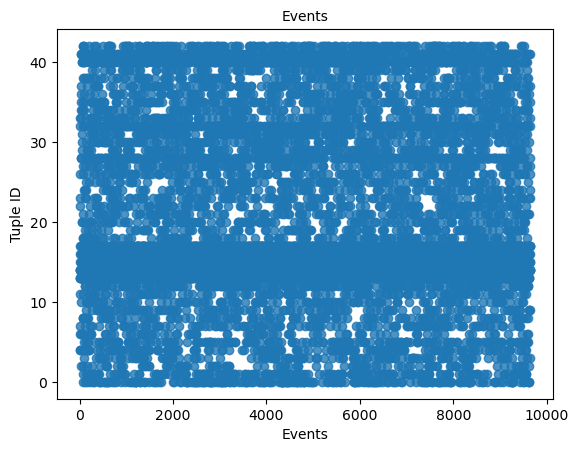

In [51]:
# Events only plot
fig, ax = plt.subplots()
plt.title('Events', fontsize='10')
ax.set_xlabel("Events", fontsize='10')
ax.set_ylabel("Tuple ID", fontsize='10')
ax.scatter(rows, ids, alpha=0.8)
plt.show()

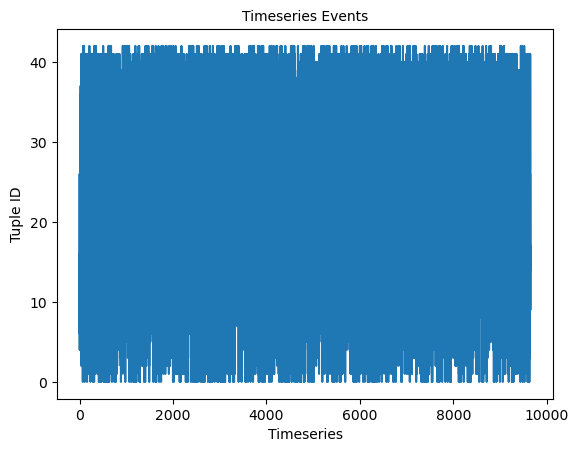

In [52]:
# Matrix Profil only
fig, ax = plt.subplots()
plt.title('Timeseries Events', fontsize='10')
ax.set_xlabel("Timeseries", fontsize='10')
ax.set_ylabel("Tuple ID", fontsize='10')
ax.plot(event_series)
# Plot motif and nearest neighbor window
plt.show()

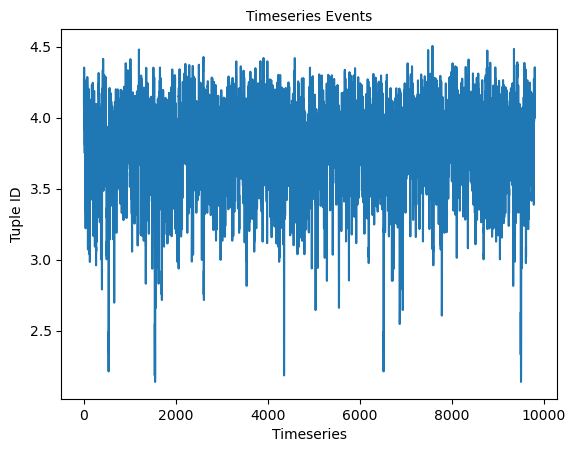

In [17]:
#Timeseries plot only
fig, ax = plt.subplots()
plt.title('Timeseries Events', fontsize='10')
ax.set_xlabel("Timeseries", fontsize='10')
ax.set_ylabel("Tuple ID", fontsize='10')
ax.plot(tm_matrix[:, 0])
plt.show()

### Run for smartRPA based file with multi dimensional data

Does not return proper results yet. Maybe the uni dimensional version works better.
Consider improvement for uni-dimensional as more important then multi-dimensional discovery for now. > Embedding, co-occurance, etc...

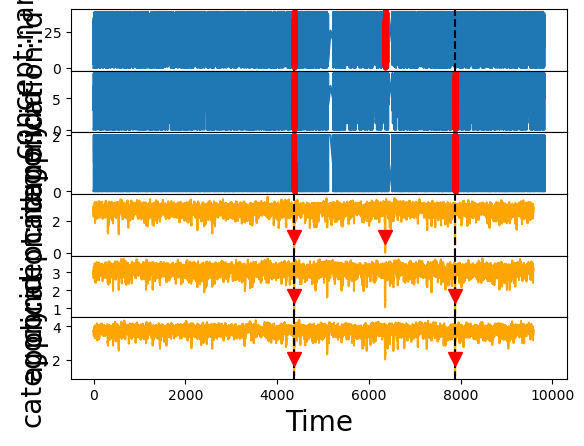

In [32]:
df = df[['concept:name:id', 'application:id', 'category:id']]
df['concept:name:id'] = df['concept:name:id'].astype(float)
df['application:id'] = df['application:id'].astype(float)
df['category:id'] = df['category:id'].astype(float)

m=20
mps, indices = stumpy.mstump(df, m)
motifs_idx = np.argmin(mps, axis=1)
nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0})

for k, dim_name in enumerate(df.columns):
    axs[k].set_ylabel(dim_name, fontsize='20')
    axs[k].plot(df[dim_name])
    axs[k].set_xlabel('Time', fontsize ='20')

    axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='20')
    axs[k + mps.shape[0]].plot(mps[k], c='orange')
    axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='20')

    axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

    if dim_name != 'T3':
        axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), df[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
        axs[k].plot(range(nn_idx[k], nn_idx[k] + m), df[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')
    else:
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='black')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='black')

plt.show()

## Find Top-K Motifs

From https://stumpy.readthedocs.io/en/latest/Tutorial_STUMPY_Basics.html#Find-Top-K-Motifs

Now that you’ve computed the matrix profile, mp, for your time series and identified the best global motif, you may be interested in discovering other motifs within your data. However, you’ll immediately learn that doing something like top_10_motifs_idx = np.argsort(mp[:, 0])[10] doesn’t actually get you what you want and that’s because this only returns the index locations that are likely going to be close to the global motif! Instead, after identifying the best motif (i.e., the matrix profile location with the smallest value), you first need to exclude the local area (i.e., an exclusion zone) surrounding the motif pair by setting their matrix profile values to np.inf before searching for the next motif. Then, you’ll need to repeat the “exclude-and-search” process for each subsequent motif. Luckily, STUMPY offers two additional functions, namely, stumpy.motifs and stumpy.match, that help simplify this process. While it is beyond the scope of this basic tutorial, we encourage you to check them out!



In [32]:
# ToDo: When a motif is discovered: Find all equal motifs in the data and extract (CTRL+X) them from the frame into a new frame
#    this new frame contains all variants of a motif and could be input to smartRPAs routine variant discovery
# Repeat until no motifs are found anymore

# min_neighbours: With min_neighbours one can select how often a process motif has to appear at least to be relevant => map this to number of executions
# max_matches
top_motifs = stumpy.motifs(T=event_series, P=tm_matrix[:,0], min_neighbors=1, max_matches=10)
top_motifs[1][0]

array([ 5961, 19019,  2494,  5262, 11798,  3851, 17583,  5670,  4612,
       10122], dtype=int64)

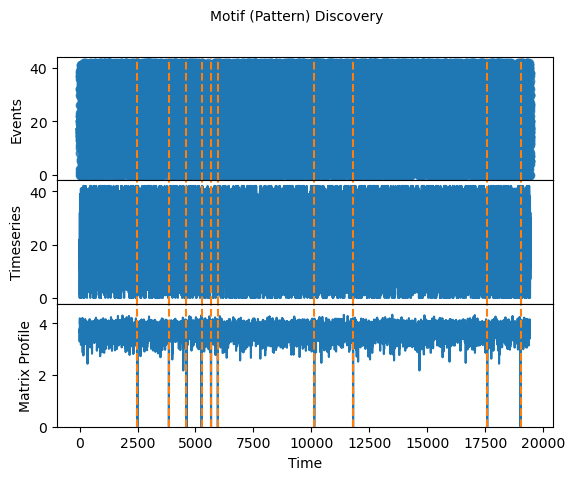

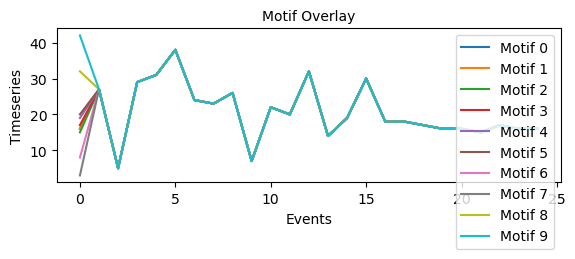

In [33]:
#Plot Event data
fig2, axs2 = plt.subplots(3, sharex=True, gridspec_kw={'hspace': 0})
plt.suptitle('Motif (Pattern) Discovery', fontsize='10')

axs2[0].scatter(rows, ids, alpha=0.8)
axs2[0].set_ylabel('Events', fontsize='10')
# Plot Timeseries data
axs2[1].plot(event_series)
axs2[1].set_ylabel('Timeseries', fontsize='10')
rect = Rectangle((motif_idx_tm, 0), window_size, event_series.max(), facecolor='lightgrey')
# axs2[1].add_patch(rect)
rect = Rectangle((nearest_neighbor_idx_tm, 0), window_size, event_series.max(), facecolor='lightgrey')
# axs2[1].add_patch(rect)
# Plot Matrix profiles
axs2[2].set_xlabel('Time', fontsize ='10')
axs2[2].set_ylabel('Matrix Profile', fontsize='10')
axs2[2].set_ylim(top=tm_matrix[:, 0].max()*1.1) #displaying the max value with some uplift for space in Graph
axs2[2].plot(tm_matrix[:, 0])
# Adding Dashed lines
for discovered in top_motifs[1][0]:
    axs2[0].axvline(x=discovered, linestyle="dashed",color='C1')
    axs2[1].axvline(x=discovered, linestyle="dashed",color='C1')
    axs2[2].axvline(x=discovered, linestyle="dashed",color='C1')

# Display Pattern overlay
fig, ax = plt.subplots(figsize=(6.5, 2))
plt.title('Motif Overlay', fontsize='10')
ax.set_xlabel("Events", fontsize='10')
ax.set_ylabel("Timeseries", fontsize='10')
# Plot motif and nearest neighbor window
for i, val in enumerate(top_motifs[1][0]):
    colorPlot = 'C' + str(i)
    ax.plot(event_series[val:val+window_size], color=colorPlot, label=f"Motif {i}")
    
plt.legend(loc="best",fontsize=10)
plt.show()

plt.show()

In [34]:
print(len(df))
df.drop(range(top_motifs[1][0][4],top_motifs[1][0][4]+window_size),axis=0,inplace=True)
print(len(df))

9755
9730


In [ ]:
# Creates a dataframe that contains all paths from the top_motifs result 
allMotifsDF = pd.DataFrame() 
for i, element in enumerate(top_motifs[1][0]):
    motif_start = top_motifs[1][0][i]
    motifFrame = df.loc[motif_start:motif_start+window_size]
    allMotifsDF = pd.concat([allMotifsDF,motifFrame])
    print(motifFrame)

allMotifsDF

### Matching motives from most appearing motifs

Find all matches of a query `Q` in a time series `T`

The indices of subsequences whose distances to `Q` are less than or equal to `max_distance`, sorted by distance (lowest to highest). Around each occurrence an exclusion zone is applied before searching for the next.

In [23]:
firstMotif = top_motifs[1][0][0]
foundMotif = event_series[firstMotif:firstMotif+window_size]
matchingPatterns = stumpy.match(Q=foundMotif,T=event_series,max_distance=1.0)
print(firstMotif)
print(matchingPatterns)
print(f"The amount of motifs found with matching patterns is {len(matchingPatterns)}")

1547
[[2.580956827951785e-07 1547]]
The amount of motifs found with matching patterns is 1


# Adding Boundary Information 
Utilizing the method proposed by Rebmann and van der Aa (https://link.springer.com/chapter/10.1007/978-3-031-34560-9_9) in https://github.com/a-rebmann/task-recognition

## Identify process start and end

1. It is necessary to identify if it is the same process that was identified.
2. It is necessary to identify the start and end of the process:
    Where is the initial action? What is an initial action? What is the last action?

In [ ]:
from util.uipatternminer import UIPatternMiner
from util.const import path_to_files, log_dir, value_attributes, semantic_attributes, context_attributes, MICROTASK, CASEID, USERACTIONID, case_ids, timeStamps

# 2. Get Micro Tasks by creating uipatternminer Class Object
context_atts = context_attributes
value_atts = value_attributes
semantic_atts = semantic_attributes

for file in filenamesList:
    case_ids = {file: "case:concept:name"}
    timeStamps = {file: "time:timestamp"}

miner = UIPatternMiner(df, case_ids, timeStamps, context_atts, value_atts, semantic_atts)
miner.get_micro_tasks()
boundary_indices = miner.get_attribute("boundaries")

# Add column with boundaries to df
df[MICROTASK] = ''
for index in boundary_indices:
    df.at[index, MICROTASK] = 'True'

# Include calculate_time_difference 
# Adding a weekly average as seperator (gap attribute) might be a solution to get better "segmenetation" of task switches as described in doi.org/10.1145/2063576.2063947
df = calculate_time_difference(df, miner.timeStamp, gap=300, n_rolling=10)

# Merge case boundary col, time Difference Boundary, and micro task boundary col in isBoundaryCol
df['isBoundary'] = df.apply(lambda row: row[MICROTASK] == 'True' or row['timeDifferenceBoolStatic'] == True or row['timeDifferenceBoolRolling'] == True, axis=1)

df[[MICROTASK,"timeDifferenceBoolStatic","timeDifferenceBoolRolling",'isBoundary','timeDifference',"n-running-difference"]]

In [ ]:
result = df.groupby('isBoundary')['isBoundary'].value_counts()
print(result)

print(len(df))

In [ ]:
# Set the index to the motif discovery by single motif discovery method
index_to_check = motif_idx_tm
end_of_window = index_to_check+window_size

try:
  start_forward_index, start_backward_index = find_closest_boundaries(df.copy(), index_to_check)
  end_forward_index, end_backward_index = find_closest_boundaries(df.copy(), end_of_window)

  print(f"The actual motif start is at index {index_to_check} and ends at {index_to_check+window_size} with window size being {window_size}.")
  print(f"Start Forward closest boundary index: {start_forward_index} and {abs(index_to_check-start_forward_index)} actions away.")
  print(f"Start Backward closest boundary index: {start_backward_index} and {abs(index_to_check-start_backward_index)} actions away.")  
  print(f"\nEnd Forward closest boundary index: {end_forward_index} and {abs(end_of_window-end_forward_index)} actions away.")
  print(f"End Backward closest boundary index: {end_backward_index} and {abs(end_of_window-end_backward_index)} actions away.")  

except ValueError as e:
  print(e)